# collecting more data to mitigate overfitting

When possible, collecting more training data can be an effective strategy to help mitigate model overfitting.

Importantly, collecting more data allows you to keep the other aspects of the model and the training process the same. In many cases, data scientists develop a specific statistical model in order to address a particular question or hypothesis. There may be a good reason to use the model you are using to perform an analysis, and simplifying the model in order to match the amount of available training data might negatively impact the information you can get out of the modeling process.

Similarly, data normalization and model regularization techniques can effectively mitigate model overfitting, but they can also alter the best-fit values of the model's parameters, which can impact the interpretability of the results. In many cases, the *values* of the model's parametes can have *meaning* within the problem domain. Researchers use the fitted values of model parameters to help them better understand the structure of the data and how it relates to important concepts in the field of study. In some cases, the model's parameter values are *more* important to a particular study objective than other features of the model. Data normalization and model regularization (we'll look at them in more detail later on) can alter the model's parameter values, which can make them less informative.

From a computational modeling perspective, collecting more data is *easy*; the only downside is that the training process will take more time, because more training samples need to be evaluated during each training epoch. In the 'real world', however, collecting additional data can be *extremely* costly and time-consuming.

To help side-step the additional costs associated with collecting more data in the real world, many studies try to incorporate new data from *other* existing studies that are using similar data to address similar questions. This approach of incorporating different data from multiple different studies is sometimes called a "meta-analysis" approach.

While meta-analysis can be an effective strategy for increasing the *amount* of training data samples, it can also raise new data analysis problems. In nearly all cases, data from different studies is, well... different. Various studies can differ in their sampling strategies, in the precise data fields being collected, in the types of subjects or sites from which data are collected, and in how the data samples are organized, processed and evaluated for quality. All these differences across studies can introduce complex 'heterogeneity' into the combined meta-data set. If data from multiple sources is not carefully integrated, it can cause *huge* problems for data analysis, including analysis using neural networks.

## determining the 'right' amount of data at the start

Many research studies 'evolve' over time, often shifting focus as the study proceeds. This is a very poor practice from a data-analysis point of view, and it is often actively discouraged by statisticians and data scientists. However, it is part of doing research and often can't be avoided. Many research studies don't even *consult* data analysis experts until *after* data have been collected. This is extremely frustrating for data scientists and can severely limit the types of analyises that can be reliably conducted, limiting the value of the study.

Ideally, data scientists should be *part* of the research team from the very beginning. Data analysts understand what can and can't be done with data. Getting their input on study design *before* data are collected helps ensure that the data that are collected will be appropriate to reliably support the goals of the study and avoid any technical analysis problems that could undermine the statistical validity of the results. Fortunately, including data-science 'experts' in early study development is increasingly becoming 'standard practice' in scientific and industry research.

## evaluating overfitting potential using simulated data

One simple thing that data scientists can do to help mitigate potential overfitting *before* data are collected is to evaluate the *amount* of training data required to reduce overfitting of a specified neural network model using simulated data.

In traditional statistics, as "power analysis" is often done before a research study, in order to determine the number of data samples required to reliably detect an effect of the expected magnitude. This type of analysis places a *lower bound* on the amount of data samples a study should collect. The result of a power anlaysis basically tells the research team that they *must* collect *at least* this number of data samples to have any hope of reliably identifying the effect they hypothesize they will observe. This type of approach is most appropriate to use when the statistical model is *very* simple; it doesn't directly address potential overfitting when the model is complex.

We can use an approach similar to 'power analysis' to help identify, given a specified neural network model, how much data we need to collect to effectively reduce model overfitting during the training process.

In this case, we simply simulate training data sets of increasing sizes and evaluate the neural network model's overfitting using a training-validation data split. The *smallest* data set for which model overfitting is reduced to a sufficiently low amount represents the *minimum* amount of data we would need to collect to mitigate overfitting. In practice, this approach relies on our ability to simulate training data similar to the 'real' data we expect to collect.

In the below code cell, we simulate a linear data set of 100 samples with 2 explanatory variables and a single response variable.

We split the data set into 60% training and 40% validation data, and we train a complex neural network for 500 epochs using a batch size of 10, stochastic gradient descent optimization and mean squared error loss.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
996/996 [==============================] - 2s 2ms/step - loss: 0.0378 - val_loss: 0.0106
Epoch 2/500
996/996 [==============================

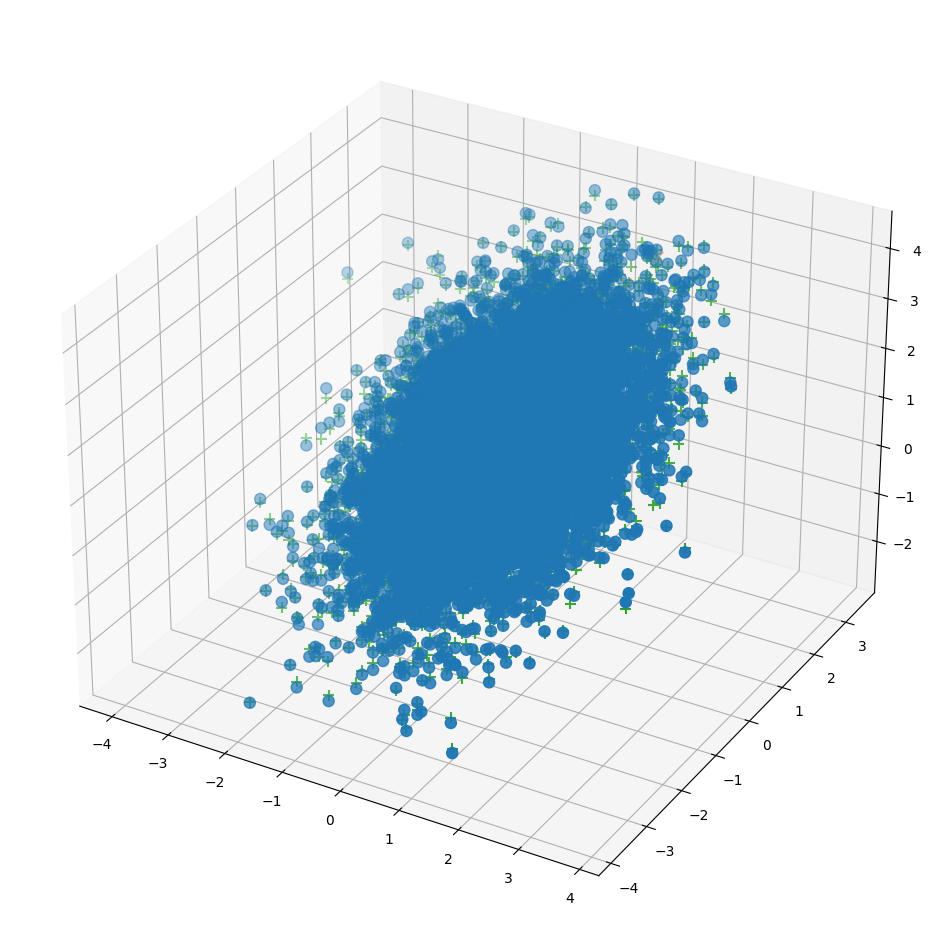

In [2]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=10000,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

If you scroll back up through the training output, you will see that this model has 8,577 trainable parameters. After training, my model had a mean squared error loss on the *training* data of < 0.005 and a *validation* loss of > 0.01, which would be a pretty clear sign of overfitting. Of course, your results will likely vary somewhat.

In the 3D plot, many of the model's fitted values (green +) are very close to training examples (blue circles), which would be indicative of overfitting, although it's pretty difficult to reliably evaluate overfitting from a graph.

Let's see what happens if we increase the amount of training data.

Change line 7 in the previous code cell, so instead of simulating 100 total data samples:

    n_samples=100,

You simulate 1000 total data samples:

    n_samples=1000,

Keep everything else the same, so we'll continue to use only 40 samples for validation. And we'll keep the training procedure unchanged. Of course, the model should remain the same, as well.

If you re-run the above code cell with 1000 simulated data samples, you should see the loss on the training data increase somewhat (in my case, the training loss was ~0.0095 after 500 epochs), and the validation loss might decrease a bit, as well (in my case, it was still around 0.01). The plot has *much* more data points and is pretty unreadable!

You probably noticed that the training time *increased* substantially, due to the increased number of data samples.

Just for 'fun', let's increase the amount of total training data even more, by setting:

    n_samples=10000,

on line 7 in the previous code cell. Now we have slightly *more* training data samples than parameters in the neural network (8,577).

This training run will likely take significantly more time, but it should reduce overfitting to a fairly negligible impact.

You may have noticed that, with *more* data, the number of epochs required to find the approximate minimum of the loss function appears to have *decreased* quite a bit! Training reaches a *stable* minimum *much* faster with more data. This is *generally* the case: more data means there is less of an impact of stochasticity on the training process. Models can 'find' their optimum paramter values much faster, because more data provides more accurate information about the *patterns* in the data, and noise has less of an impact. So, you may be able to reduce the number of epochs in your training run and get better parameter estimates if you have more data samples.